# Numerical scheme sandbox for GPU-EPS Hav project

## TODO
 0. Initialize boundary (before first time step)
 1. Implement time-stepping (full simulation cycle)
 2. Visualize results
 3. Validate/verify/check
 4. (Implement scheme in C++/OpenCL C)

## Do initialization and define plot functions

In [1]:
#Lets have matplotlib "inline"
%pylab inline

#Lets have large and high-res figures
%config InlineBackend.figure_format = 'retina'
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import numpy as np

#np.set_printoptions(precision=4, suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [11]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

def plot_vars(xm, ym, B, h):
    # Twice as wide as it is tall.
    fig = plt.figure(figsize=plt.figaspect(0.5))
    
    # First plot
    ax = fig.add_subplot(1, 1, 1, projection='3d')
 
    xxm, yym = np.meshgrid(xm, ym)
   
    surf = ax.plot_surface(yym, xxm, h, rstride=1, cstride=1, cmap=None,
            linewidth=0, antialiased=False)

    # Second plot
    ax.plot_wireframe(yym, xxm, B, rstride=1, cstride=1)

    plt.show()
    
    #plt.savefig('foo.png', format='png', bbox_inches='tight')

def plot_vars_separate(xm, ym, B, h):
    # Twice as wide as it is tall.
    fig = plt.figure(figsize=plt.figaspect(0.5))
    
    # First subplot
    ax = fig.add_subplot(1, 2, 1, projection='3d')
 
    xxm, yym = np.meshgrid(xm, ym)
   
    surf = ax.plot_surface(yym, xxm, h, rstride=1, cstride=1, cmap=None,
            linewidth=0, antialiased=False)

    # Second subplot
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.plot_wireframe(yym, xxm, B, rstride=1, cstride=1)


    plt.show()

## Define parameters and initial conditions

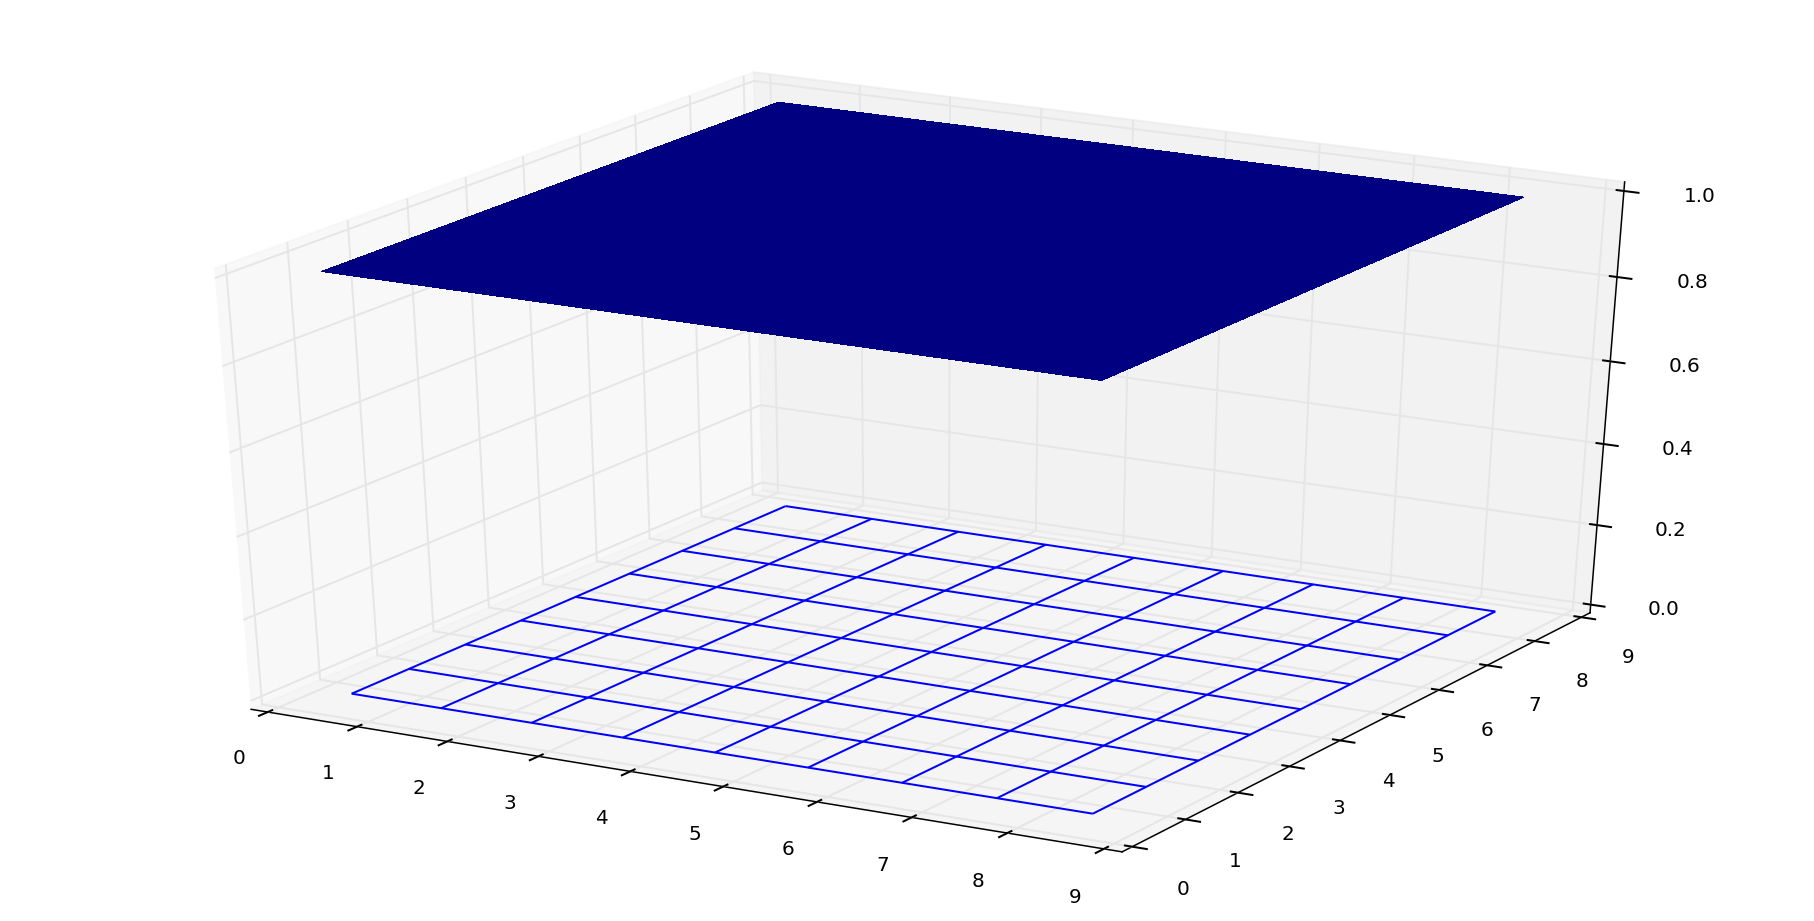

In [3]:
# Define grid (w/o ghost cells)
nx = 8
ny = 8

# Define our physical variables
x = np.linspace(0.0, (nx+2)-1.0, nx+2)
y = np.linspace(0.0, (ny+2)-1.0, ny+2)

# Cell midpoints
xm = np.linspace(0.5, (nx+1)-0.5, nx+1)
ym = np.linspace(0.5, (ny+1)-0.5, ny+1)

dx = 0.1
dy = 0.1
dt = 0.0001
g = 9.81

# No friction (yet)
R = 1;

# No coriolis effect (yet)
F = 1;

# Bathymetry
B = np.zeros([nx+1, ny+1]);

#
# Initial conditions
#
w = np.ones([nx+1, ny+1]); # water height

# Make sure that h (water depth) is non-negative initially (w =< B should probably throw an error...)
w = np.maximum(w, B)

h = w - B; # water depth
H = h # equilibrium solution => eta = 0
U = np.zeros([nx+2, ny-1]); # no initial velocity in x-direction
V = np.zeros([nx-1, ny+2]); # no initial velocity in y-direction

eta = np.zeros([nx+1, ny+1]); # deviation from sea surface equilibrium depth, H

# Plot B and h(eta+H) with ghost cells
plot_vars(xm, ym, B, eta+H)

## Run-through of numerical scheme (2D)

We implement a finite-difference based scheme on a Cartesian staggered grid.

Since the variables needs to be evaluated at a different location than they are stored, we do a reconstruction of the variables using (bi)linear interpolation.

In [4]:
def reconstruct_H(H):
    # H (hat) reconstructed
    Hr_u = np.zeros([nx, ny+1]);
    Hr_v = np.zeros([nx+1, ny]);
    Hr_u[:,:] = 0.5 * (H[:-1,:] + H[1:,:]); # x-direction
    Hr_v[:,:] = 0.5 * (H[:,:-1] + H[:,1:]); # y-direction
    
    return [Hr_u, Hr_v];

#[Hr_u, Hr_v] = reconstruct_H(H);

First, we compute the depth-averaged velocity in the $x$-direction, U, at cell intersections:

In [5]:
def compute_U(eta1, Hr_u, U1, V1):
    B_u = 1 + R*dt / Hr_u;

    P_u = g * Hr_u * (eta1[1:,:] - eta1[:-1,:]) / dx;

    # V (hat) reconstructed (tricky... triple-check!)
    Vr = np.zeros([nx, ny+1]);
    Vr[1:-1,0] = 0.5 * (V1[1:,1] + V1[:-1,1]);
    Vr[1:-1,1:-1] = 0.25 * (V1[1:,1:-2] + V1[:-1,1:-2] + V1[1:,2:-1] + V1[:-1,2:-1]);
    Vr[1:-1,-1] = 0.5 * (V1[1:,-2] + V1[:-1,-2]);

    # Boundary conditions in x-direction, Vr (is this correct...? triple-check!)
    Vr[0,:] = Vr[1,:];
    Vr[-1,:] = Vr[-2,:];
    
    # DEBUG
    """
    print "\n";
    print "Hr_u";
    print Hr_u;
    print "\n Vr";
    print Vr;
    print "\n";
    """

    # Do not compute U in the ghost cells => index with 1:-1 in the y-direction
    U[1:-1,:] = 1 / B_u[:,1:-1] * (U1[1:-1,:] + dt * (F*Vr[:,1:-1] - P_u[:,1:-1]));
    
    return U;

#U = compute_U(eta, Hr_u, U, V);

Second, we compute the depth-averaged velocity in $y$-direction, V, at cell intersections:

In [6]:
def compute_V(eta1, Hr_v, U1, V1):
    B_v = 1 + R*dt / Hr_v;

    P_v = g * Hr_v * (eta1[:,1:] - eta1[:,:-1]) / dy;

    # U (hat) reconstructed (tricky... triple-check!)
    Ur = np.zeros([nx+1, ny]);
    Ur[0,1:-1] = 0.5 * (U1[1,1:] + U1[1,:-1]);
    Ur[1:-1,1:-1] = 0.25 * (U1[1:-2,1:] + U1[1:-2,:-1] + U1[2:-1,1:] + U1[2:-1,:-1]);
    Ur[-1,1:-1] = 0.5 * (U1[-2,1:] + U1[-2,:-1]);

    # Boundary conditions in y-direction, Ur (is this correct...? triple-check!)
    Ur[:,0] = Ur[:,1];
    Ur[:,-1] = Ur[:,-2];
    
    # DEBUG
    """
    print "\n";
    print "Hr_v";
    print Hr_v;
    print "\n Ur";
    print Ur;
    print "\n";
    """

    # Do not compute V in the ghost cells => index with 1:-1 in the x-direction
    V[:,1: -1] = 1 / B_v[1:-1,:] * (V1[:,1:-1] + dt * (F*Ur[1:-1,:] - P_v[1:-1,:]));
    
    return V;

#V = compute_V(eta, Hr_v, U, V);

Last, we compute the sea surface deviation, $\eta$, at cell centers:

In [7]:
def compute_eta(eta1, U1, V1):
    eta[1:-1,1:-1] = eta1[1:-1,1:-1] - dt/dx * (U1[1:-2,:] - U1[2:-1,:]) - dt/dy * (V1[:,1:-2] - V1[:,2:-1]);
    
    return eta;

# Update internal domain
#eta = compute_eta(eta, U, V);

After a complete time step, boundary conditions are applied on variables $U$, $V$, and $\eta$:

In [8]:
def compute_BC(eta, U, V):
    # Boundary conditions, eta
    eta[:,-1] = eta[:,-2]; # north
    eta[-1,:] = eta[-2,:]; # east
    eta[:,0] = eta[:,1]; # south
    eta[0,:] = eta[1,:]; # west

    # Boundary conditions, U (north and south can probably be removed...)
    U[:,-1] = U[:,-2]; # north
    U[-1,:] = U[-2,:]; # east
    U[:,0] = U[:,1]; # south
    U[0,:] = U[1,:]; # west

    # Boundary conditions, V (east and west can probably be removed...)
    V[:,-1] = V[:,-2]; # north
    V[-1,:] = V[-2,:]; # east
    V[:,0] = V[:,1]; # south
    V[0,:] = V[1,:]; # west
    
    return [eta, U, V];

#[eta, U, V] = compute_BC(eta, U, V);

## One full simulation step

eta
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.  5.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]

H
[[ 100.  100.  100.  100.  100.  100.  100.  100.  100.]
 [ 100.  100.  100.  100.  100.  100.  100.  100.  100.]
 [ 100.  100.  100.  100.  100.  100.  100.  100.  100.]
 [ 100.  100.  100.  100.  100.  100.  100.  100.  100.]
 [ 100.  100.  100.  100.  100.  100.  100.  100.  100.]
 [ 100.  100.  100.  100.  100.  100.  100.  100.  100.]
 [ 100.  100.  100.  100.  100.  100.  100.  100.  100.]
 [ 100.  100.  100.  100.  100.  100.  100.  100.  100.]
 [ 100.  100.  100.  100.  100.  100.  100.  100.  100.]]

eta+H
[[ 100.  100.  100.  100.  100.  100.  100.  100.  100.]
 [ 105.  105.  105.  105.  105.  105.  105.  105.  105.]
 [ 100

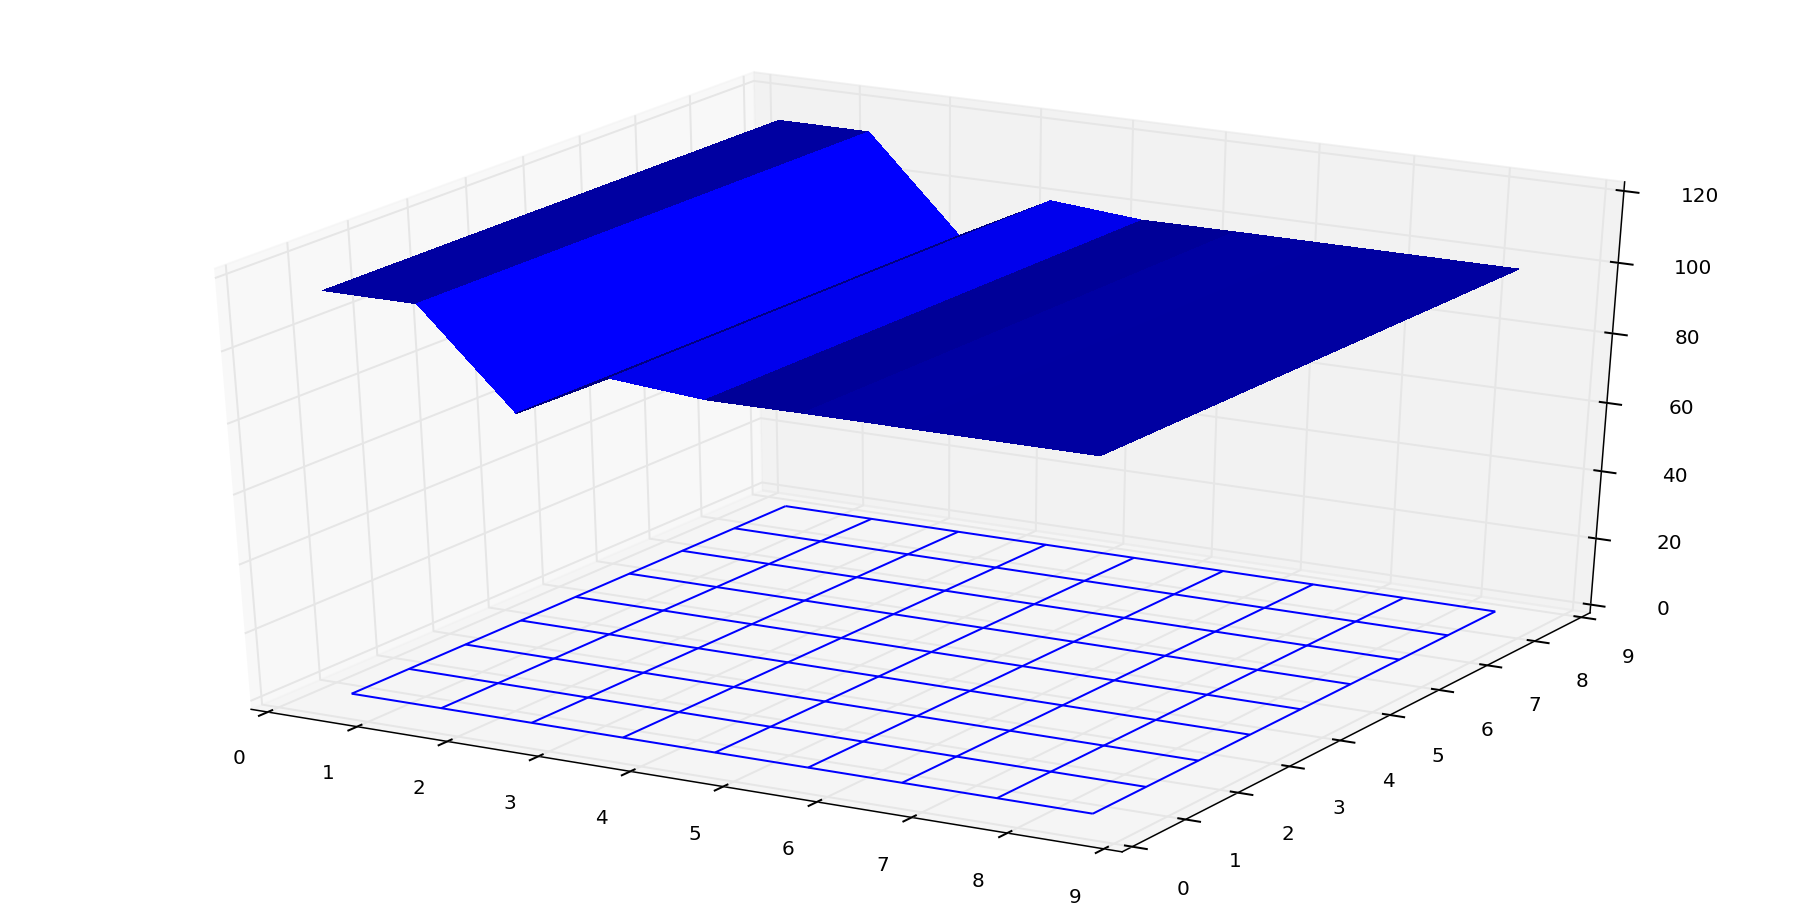

In [9]:
def timestep(eta1, U1, V1):
    # XXX: We probably only need to do this once per simulation?
    [Hr_u, Hr_v] = reconstruct_H(H);
    
    U = compute_U(eta1, Hr_u, U1, V1);
    V = compute_V(eta1, Hr_v, U, V1);
    eta = compute_eta(eta1, U, V);
    
    return [eta, U, V];

# Define initial conditions, initialize variables, and do time stepping
B = np.zeros([nx+1, ny+1]); # bathymetry
# XXX: H must be initialized from B and w for all cases other than flat bathymetry
H = np.ones([nx+1, ny+1]); # sea surface equilibrium depth
H = H*100; # let us increase the sea surface equilibrium depth
eta = np.zeros([nx+1, ny+1]); # deviation from sea surface equilibrium depth, H

# Flat surface
#eta[:, :] = 0.1;

# Raised square in center of domain
#eta[3:-3, 3:-3] = 0.5;

# Waves from both boundaries in x-direction
eta[1,:] = 5.0;
#eta[-2,:] = 0.1;

# Waves from both boundaries in y-direction
#eta[:,1] = 0.1;
#eta[:,-2] = 0.1;

U = np.zeros([nx+2, ny-1]); # no initial velocity in x-direction
V = np.zeros([nx-1, ny+2]); # no initial velocity in y-direction

print "eta";
print eta;
print "\n" + "H";
print H;
print "\n" + "eta+H";
print eta+H;
print "\n";

# total mass should not change
print "Original Mass: " + str(np.sum(eta[1:-1,1:-1]+H[1:-1,1:-1])) + "\n"

#CONT HERE: Check increased mass, unsymmetry in Ur and Vr, and diagonal symmetry error

for i in range(0,50,1):
    print "Time step: " + str(i)
    eta1 = np.copy(eta)
    U1 = np.copy(U)
    V1 = np.copy(V)
    [eta, U, V] = timestep(eta1, U1, V1);
    [eta, U, V] = compute_BC(eta, U, V);
    # total mass should not change
    print "Mass: " + str(np.sum(eta[1:-1,1:-1]+H[1:-1,1:-1])) + "\n"

print "eta+H";
print eta+H;
print "U";
print U;
print "V";
print V;

# Plot B and h(eta+H) with ghost cells
plot_vars(xm, ym, B, eta+H);

# Full simulation

In [10]:
def run_sim(x, y, eta, H, B):    
    nt = 400
    n_figs = 16
    fig_every = nt/float(n_figs-1)
    next_fig = 0.0
    
    nx = int(ceil(sqrt(n_figs)))
    ny = nx
    if (nx*(ny-1) > n_figs):
        ny = ny-1
    fig, ax = subplots(nx, ny, sharex=True, sharey=True, squeeze=True)
    ax = np.reshape(ax, nx*ny)
    
    for i in range(nt):
        [eta, U, V] = timestep(x, y, eta, H, B)
        
        if (i >= next_fig or i==nt-1):
            print "Step ",i,", sum water elevation: ",np.sum(eta+H)
            fig_no = i/(fig_every-1)
            sca(ax[fig_no])
            plot_vars(xm, ym, B, eta+H)
            title("Step " + str(i))
            next_fig += fig_every

def run_case1():
    """Run case 1: Flat bed, wall boundary, raised cylinder"""
    #
    # XXX: !!! Continue here !!! (Only eta, w, and B should be necessary input to start a simulation.)
    #
    B = np.zeros([nx+1, ny+1]);

    #
    # Initial conditions
    #
    w = np.ones([nx+1, ny+1]); # water height

    # Make sure that h (water depth) is non-negative initially (w =< B should probably throw an error...)
    w = np.maximum(w, B)

    h = w - B; # water depth
    H = h # equilibrium solution => eta = 0
    U = np.zeros([nx+2, ny-1]); # no initial velocity in x-direction
    V = np.zeros([nx-1, ny+2]); # no initial velocity in y-direction

    eta = np.zeros([nx+1, ny+1]); # deviation from sea surface equilibrium depth, H
    
    x = np.linspace(0, 99, 200)
    B = np.zeros(x.shape)
    Q = np.zeros((2, len(x)-1))
    Q[0][:len(x)/2] = 2.0
    Q[0][len(x)/2:] = 1.0
    run_sim(x, y, eta, H, B)

#run_case1();